# Bayesian linear regression in pyro

We will explore the relationship between togographic heterogeneity of a nation, measured by the Terrain Ruggedness Index, and its GDP per capita. It has been noted that, generally, terrain ruggedness correlates inversely with economic performance except in African nations where the relationship is reversed. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import seaborn as sns

import pyro
import pyro.distributions as dist

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [3]:
data

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.000,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.000,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.000,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.000,NaN,NaN,NaN,NaN,200000.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,WSM,882,Samoa,1.677,0.968,4.644,0.549,22.244,283.0,-13.738,...,0,0,0,0.000,NaN,NaN,NaN,NaN,33072.0,NaN
230,YEM,887,Yemen,2.323,2.197,6.155,0.591,33.060,52797.0,15.863,...,0,0,0,0.000,NaN,NaN,NaN,NaN,2250000.0,0.0
231,ZAF,710,South Africa,1.761,1.318,4.942,0.450,23.957,121447.0,-29.004,...,0,0,0,2030.663,6.766,3.457,6.584,4.895,486527.0,18.0
232,ZMB,894,Zambia,0.533,0.506,1.422,0.145,2.455,74339.0,-13.458,...,0,0,0,27957.102,9.027,2.389,4.849,3.253,348220.0,1.0


We will focus on `cont_africa`, `rugged`, and `rgdppc_2000`.

In [4]:
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]

We log transform GDP because it is highly skewed

In [5]:
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

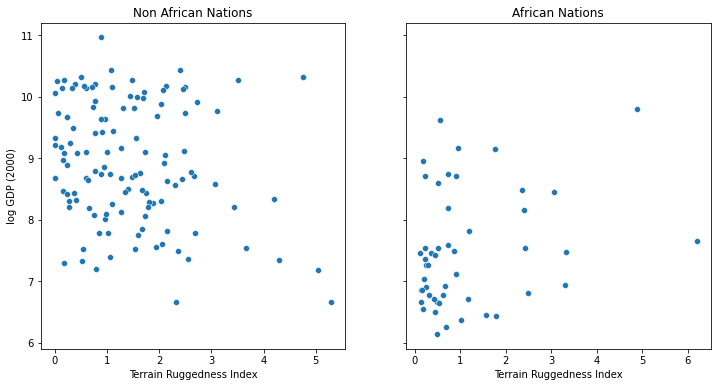

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
            y=non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We would like to predict GDP from `cont_africa` and `rugged` and will use gradient descent on `nn.Linear` to find a maximum likelihood estimate.

In [7]:
from torch import nn
from pyro.nn import PyroModule

Add a feature capturing the interaction between `cont_africa` and `rugged`

In [8]:
df['cont_africa_x_rugged'] = df['cont_africa'] * df['rugged']

In [9]:
data = torch.tensor(df[['cont_africa', 'rugged', 'cont_africa_x_rugged', 'rgdppc_2000']].values, dtype=torch.float)

In [10]:
x_data, y_data = data[:, :-1], data[:, -1]

The regression model

In [11]:
linear_reg_model = PyroModule[nn.Linear](3, 1)  # create dynamic mixin class, which subclasses PyroModule and nn.Linear. It is similar to nn.Module. Defines a model, with a .forward method

In [12]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500

In [13]:
def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

In [14]:
for j in range(num_iterations):
    loss = train()
    if (j+1) % 50 == 0:
        print(f"[iteration {j+1: 04d}] loss: {loss.item(): .4f}")

[iteration  050] loss:  2734.4949
[iteration  100] loss:  1506.0044
[iteration  150] loss:  1028.4700
[iteration  200] loss:  751.8179
[iteration  250] loss:  557.7626
[iteration  300] loss:  416.0175
[iteration  350] loss:  316.0740
[iteration  400] loss:  249.0391
[iteration  450] loss:  206.2456
[iteration  500] loss:  180.1951
[iteration  550] loss:  165.0517
[iteration  600] loss:  156.6374
[iteration  650] loss:  152.1659
[iteration  700] loss:  149.8927
[iteration  750] loss:  148.7868
[iteration  800] loss:  148.2721
[iteration  850] loss:  148.0430
[iteration  900] loss:  147.9454
[iteration  950] loss:  147.9057
[iteration  1000] loss:  147.8903
[iteration  1050] loss:  147.8845
[iteration  1100] loss:  147.8825
[iteration  1150] loss:  147.8818
[iteration  1200] loss:  147.8816
[iteration  1250] loss:  147.8816
[iteration  1300] loss:  147.8815
[iteration  1350] loss:  147.8815
[iteration  1400] loss:  147.8815
[iteration  1450] loss:  147.8815
[iteration  1500] loss:  147.8

Inspect learned parameters

In [15]:
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

weight [[-1.9480186  -0.20284522  0.39338022]]
bias [9.2232]


Plot

In [16]:
fit = df.copy()
fit['mean'] = linear_reg_model(x_data).detach().cpu().numpy()

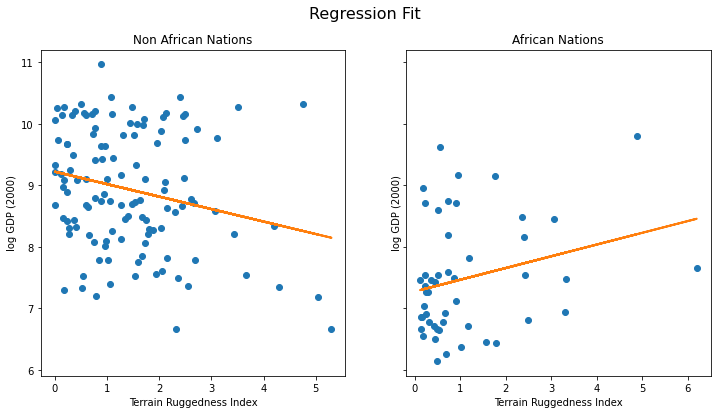

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We now seek to get some parametric uncertainty. We will use Pyro's stochastic variational inference.

## Bayesian regression with stochastic variational inference

In [18]:
from pyro.nn import PyroSample  # declares a random attribute of a corresponding PyroModule

In [19]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))  # param to sample
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1)) # param to sample
    
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.)) # param to sample
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]): # for all observations
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

For now, to keep things simple, let's use an autoguide and specified an uncorrelated multivariate normal for the variational distribution

In [20]:
from pyro.infer.autoguide import AutoDiagonalNormal

In [21]:
model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [22]:
from pyro.infer import SVI, Trace_ELBO

In [23]:
adam = pyro.optim.Adam({'lr': 0.03})  # Note we use Pyro's optim, rather than Torch's optim
svi = SVI(model, guide, adam, loss=Trace_ELBO())


In [24]:
pyro.clear_param_store()
for j in range(num_iterations):
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print(f"[iteration{j+1: 04d}] loss: {loss/len(data):.4f}")


[iteration 001] loss: 4.4399
[iteration 101] loss: 3.2544
[iteration 201] loss: 2.8214
[iteration 301] loss: 2.4079
[iteration 401] loss: 1.5731
[iteration 501] loss: 1.4564
[iteration 601] loss: 1.4656
[iteration 701] loss: 1.4695
[iteration 801] loss: 1.4762
[iteration 901] loss: 1.4719
[iteration 1001] loss: 1.4745
[iteration 1101] loss: 1.4682
[iteration 1201] loss: 1.4634
[iteration 1301] loss: 1.4608
[iteration 1401] loss: 1.4727


We can examine the optimized parameter values from Pyro's parameter store

In [25]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.1889, -1.8591, -0.2164,  0.3361,  9.1327])
AutoDiagonalNormal.scale tensor([0.0552, 0.1486, 0.0390, 0.0932, 0.0717])


The model has 5 parameters:

$$y = \sum_{i=1}^3 w_i x_i + b + \mathcal{N}(0, \sigma^2)$$

$\{w_i\}, b, \sigma$, and corresponding uncertainty

We can get parameter quantiles

In [26]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9743, 1.0075, 1.0417]),
 'linear.weight': tensor([[[-1.9593, -0.2427,  0.2732]],
 
         [[-1.8591, -0.2164,  0.3361]],
 
         [[-1.7588, -0.1901,  0.3989]]]),
 'linear.bias': tensor([[9.0843],
         [9.1327],
         [9.1810]])}

We can compare this with our maximum likelihood model

In [27]:
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

weight [[-1.9480186  -0.20284522  0.39338022]]
bias [9.2232]


and we see that the parameters are similar

## Model evaluation

Now we will make some posterior predictions

In [28]:
from pyro.infer import Predictive

In [29]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%":v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

Sample from the posterior predictive distribution, obtaining:
- The outcome (GDP)
- The return value of the model, in this case the regression line
- The regression coefficients

and also get the 90% CI for the model variables

In [48]:
predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", "obs", "_RETURN"))

In [49]:
samples = predictive(x_data)

In [50]:
pred_summary = summary(samples)

In [51]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions =  pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

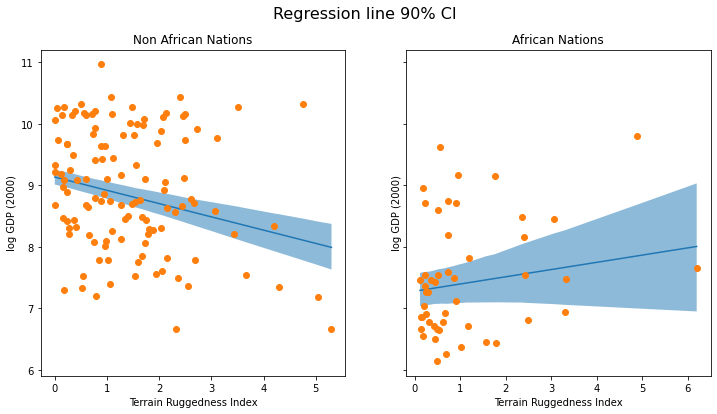

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

This gives our uncertainty in the regression line. We can also get our uncertainty in the response variable

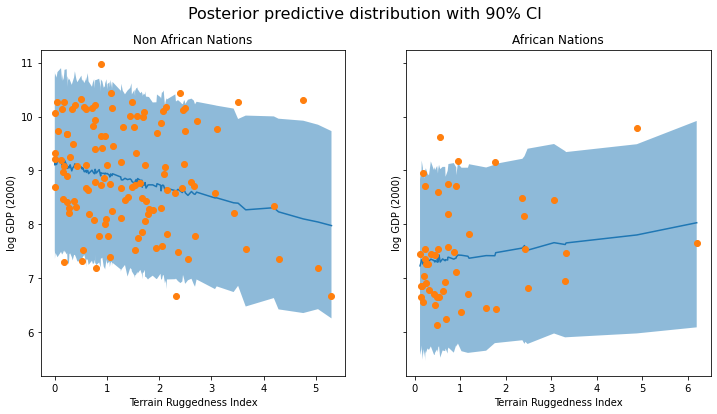

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

The above is a "posterior predictive check".

/home/juvid/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/juvid/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


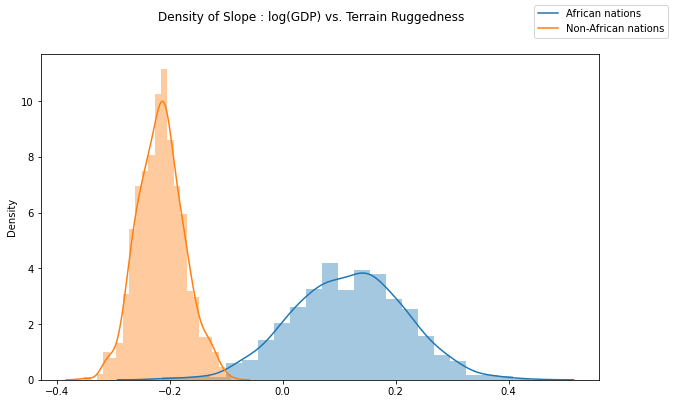

In [58]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
fig.legend()